In [1]:
import numpy as np
import time
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
from numpy.random import default_rng

from astropy.table import Table
from astropy.io import fits
import astropy.cosmology
from astropy import units as u
from astropy.coordinates import SkyCoord

In [2]:
from Corrfunc.theory import DD
from Corrfunc.theory import xi
from Corrfunc.mocks.DDrppi_mocks import DDrppi_mocks
from Corrfunc.mocks.DDtheta_mocks import DDtheta_mocks
from Corrfunc.utils import convert_3d_counts_to_cf
from Corrfunc.utils import convert_rp_pi_counts_to_wp

## Functions

In [3]:
def compute_xi(r_edges, x, y, z, x_rand, y_rand, z_rand,
               return_full_results=False):
    
    nthreads = 4
    
    start = time.time()
    autocorr=1
    res_dd = DD(autocorr, nthreads, r_edges, x, y, z, periodic=False)
    end = time.time()
    print(f'Time: {end-start:.4f} s')
    
    start = time.time()
    autocorr=0
    res_dr = DD(autocorr, nthreads, r_edges, x, y, z,
                X2=x_rand, Y2=y_rand, Z2=z_rand, periodic=False)
    end = time.time()
    print(f'Time: {end-start:.4f} s')

    start = time.time()
    autocorr=1
    res_rr = DD(autocorr, nthreads, r_edges, x_rand, y_rand, z_rand, periodic=False)
    end = time.time()
    print(f'Time: {end-start:.4f} s')
    print()
    
    N = len(x)
    N_rand = len(x_rand)
    xi = convert_3d_counts_to_cf(N, N, N_rand, N_rand,
                                     res_dd, res_dr,
                                     res_dr, res_rr)
    
    if return_full_results:
        return xi, res_dd, res_dr, res_rr
    
    return xi

In [4]:
def pure_cut(table):
    
    idx_pure = np.where( (table['gaia_crf_source']==True) |
                         ((table['host_galaxy_flag']>0) & (table['host_galaxy_flag']<6)) |
                         (table['classlabel_dsc_joint']=='quasar') |
                         (table['vari_best_class_name']=='AGN') )[0]
    return idx_pure

In [5]:
def radec_to_cartesian(r, ra, dec):
    
    theta = ra * np.pi/180
    phi = (90 - dec) * np.pi/180

    x, y, z = spherical_to_cartesian(r, theta, phi)
    return np.array([x, y, z])

In [6]:
def spherical_to_cartesian(r, theta, phi):
    x       =  r*np.cos(theta)*np.sin(phi)
    y       =  r*np.sin(theta)*np.sin(phi)
    z       =  r*np.cos(phi)
    return np.array([x, y, z])

In [7]:
def generate_shuffled_random(factor, data, rng, redshift_name='redshift_qsoc'):
    N = len(data)
    N_rand = factor*N

    i_vals = np.arange(N)

    i_radec_rand = rng.choice(i_vals, size=N_rand, replace=True)
    ra_rand = data['ra'][i_radec_rand]
    dec_rand = data['dec'][i_radec_rand]

    i_redshift_rand = rng.choice(i_vals, size=N_rand, replace=True)
    redshift_rand = data[redshift_name][i_redshift_rand]
    dist_rand = data['distance'][i_redshift_rand]
    
    x_rand, y_rand, z_rand = radec_to_cartesian(dist_rand, ra_rand, dec_rand)
    
    rand = Table([ra_rand, dec_rand, redshift_rand, dist_rand,
                      x_rand, y_rand, z_rand], 
              names=('ra', 'dec', 'redshift', 'distance', 'x', 'y', 'z'), 
              meta={'name': 'random_shuffle'})
    return rand

In [111]:
def generate_shuffled_random_magbins(factor, data, rng, mag_bins,
                                       redshift_name='redshift_qsoc', mag_name='phot_g_mean_mag'):
    
    ra_rand, dec_rand, redshift_rand, dist_rand = [], [], [], []
    x_rand, y_rand, z_rand = [], [], []
    
    
    for i in range(len(mag_bins)-1):
        idx_mbin = np.where((data[mag_name] > mag_bins[i]) & (data[mag_name] < mag_bins[i+1]))[0]
        N_mbin = len(idx_mbin)
        N_mbin_rand = factor*N_mbin
        
        i_radec_rand = rng.choice(idx_mbin, size=N_mbin_rand, replace=True)
        ra_rand_mbin = data['ra'][i_radec_rand]
        dec_rand_mbin = data['dec'][i_radec_rand]

        i_redshift_rand = rng.choice(idx_mbin, size=N_mbin_rand, replace=True)
        redshift_rand_mbin = data[redshift_name][i_redshift_rand]
        dist_rand_mbin = data['distance'][i_redshift_rand]

        x_rand_mbin, y_rand_mbin, z_rand_mbin = radec_to_cartesian(dist_rand_mbin, ra_rand_mbin, dec_rand_mbin)

        ra_rand.extend(ra_rand_mbin)
        dec_rand.extend(dec_rand_mbin)
        redshift_rand.extend(redshift_rand_mbin)
        dist_rand.extend(dist_rand_mbin)
        x_rand.extend(x_rand_mbin)
        y_rand.extend(y_rand_mbin)
        z_rand.extend(z_rand_mbin)
        
    rand = Table([ra_rand, dec_rand, redshift_rand, dist_rand,
                      x_rand, y_rand, z_rand], 
                names=('ra', 'dec', 'redshift', 'distance', 'x', 'y', 'z'), 
                meta={'name': 'random_shuffle_magbins'})
    return rand

In [158]:
def generate_shuffled_random_zbins(factor, data, rng, redshift_bins,
                                       redshift_name='redshift_qsoc'):
    
    ra_rand, dec_rand, redshift_rand, dist_rand = [], [], [], []
    x_rand, y_rand, z_rand = [], [], []
    
    
    for i in range(len(redshift_bins)-1):
        idx_mbin = np.where((data[redshift_name] > redshift_bins[i]) & (data[redshift_name] < redshift_bins[i+1]))[0]
        N_mbin = len(idx_mbin)
        N_mbin_rand = factor*N_mbin
        
        i_radec_rand = rng.choice(idx_mbin, size=N_mbin_rand, replace=True)
        ra_rand_mbin = data['ra'][i_radec_rand]
        dec_rand_mbin = data['dec'][i_radec_rand]

        i_redshift_rand = rng.choice(idx_mbin, size=N_mbin_rand, replace=True)
        redshift_rand_mbin = data[redshift_name][i_redshift_rand]
        dist_rand_mbin = data['distance'][i_redshift_rand]

        x_rand_mbin, y_rand_mbin, z_rand_mbin = radec_to_cartesian(dist_rand_mbin, ra_rand_mbin, dec_rand_mbin)

        ra_rand.extend(ra_rand_mbin)
        dec_rand.extend(dec_rand_mbin)
        redshift_rand.extend(redshift_rand_mbin)
        dist_rand.extend(dist_rand_mbin)
        x_rand.extend(x_rand_mbin)
        y_rand.extend(y_rand_mbin)
        z_rand.extend(z_rand_mbin)
        
    rand = Table([ra_rand, dec_rand, redshift_rand, dist_rand,
                      x_rand, y_rand, z_rand], 
                names=('ra', 'dec', 'redshift', 'distance', 'x', 'y', 'z'), 
                meta={'name': 'random_shuffle_magbins'})
    return rand

## Load in data

In [8]:
data_gaia = Table.read('../data/GaiaDR3_QsoCandidates2.fits', format='fits')

In [9]:
data_gaia.columns

<TableColumns names=('ra','dec','redshift_qsoc','l','b','source_id','parallax','parallax_error','pmra','pmra_error','pmdec','pmdec_error','astrometric_excess_noise','visibility_periods_used','ipd_frac_multi_peak','ruwe','phot_g_n_obs','phot_g_mean_flux','phot_g_mean_flux_error','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','phot_bp_rp_excess_factor','in_qso_candidates','gaia_crf_source','vari_best_class_name','vari_best_class_score','fractional_variability_g','qso_variability','non_qso_variability','vari_agn_membership_score','classprob_dsc_combmod_quasar','classprob_dsc_combmod_galaxy','classlabel_dsc','classlabel_dsc_joint','classlabel_oa','redshift_qsoc_lower','redshift_qsoc_upper','zscore_qsoc','flags_qsoc','n_transits','intensity_quasar','intensity_quasar_error','host_galaxy_detected','intensity_hostgalaxy','intensity_hostgalaxy_error','radius_hostgalaxy','radius_hostgalaxy_error','host_galaxy_flag','source_selection_flags','allwise_oid','designation','w1mpro','w2mpro','

Text(0, 0.5, 'number per bin')

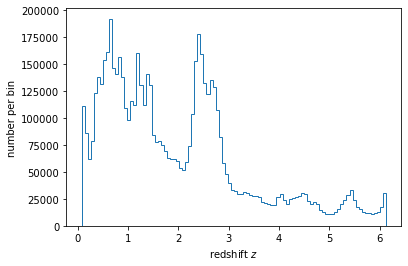

In [10]:
plt.hist(data_gaia['redshift_qsoc'], bins=100, histtype='step')
plt.xlabel(r'redshift $z$')
plt.ylabel('number per bin')

## Make purer sample

In [11]:
print(len(np.where(data_gaia['gaia_crf_source']==True)[0]))
print(len(np.where((data_gaia['host_galaxy_flag']<6) & (data_gaia['host_galaxy_flag']>0))[0]))
print(len(np.where(data_gaia['classlabel_dsc_joint']=='quasar')[0]))
print(len(np.where(data_gaia['vari_best_class_name']=='AGN')[0]))

1614173
925939
547201
1035207


In [12]:
idx_pure = pure_cut(data_gaia)
data = data_gaia[idx_pure]
len(data)

1942825

### Convert to cartesian

In [13]:
cosmo = astropy.cosmology.Planck15
dist = (cosmo.comoving_distance(data['redshift_qsoc'])*cosmo.h).value # convert to Mpc/h
data.add_column(dist, name='distance')

In [14]:
x, y, z = radec_to_cartesian(data['distance'], data['ra'], data['dec'])
data.add_column(x, name='x')
data.add_column(y, name='y')
data.add_column(z, name='z')

### Match to SDSS

In [15]:
tab_sdss = Table.read('../data/SDSS_DR16Q_v4.fits', format = 'fits')

c1 = SkyCoord(ra=tab_sdss['RA']*u.degree, dec=tab_sdss['DEC']*u.degree, frame='icrs')   
c2 = SkyCoord(ra=data['ra'], dec=data['dec'], frame='icrs') 

#c2.match_to_catalog_sky(c1) 
x1 = c2.search_around_sky(c1, 1*u.arcsec)
x2 = c2.search_around_sky(c1, 2*u.arcsec)
x3 = c2.search_around_sky(c1, 3*u.arcsec)

In [16]:
# matched sample (~400,000)
data_sdss = data[x3[1]]

# with redshifts
data_sdss.add_column(tab_sdss['Z'][x3[0]], name='redshift_sdss')
data_sdss = data_sdss[data_sdss['redshift_sdss'] > 0]
len(data_sdss)

400543

In [17]:
cosmo = astropy.cosmology.Planck15
dist_sdss = (cosmo.comoving_distance(data_sdss['redshift_sdss'])*cosmo.h).value # convert to Mpc/h
data_sdss.replace_column('distance', dist_sdss)

In [18]:
x_sdss, y_sdss, z_sdss = radec_to_cartesian(data_sdss['distance'], data_sdss['ra'], data_sdss['dec'])
data_sdss.replace_column('x', x_sdss)
data_sdss.replace_column('y', y_sdss)
data_sdss.replace_column('z', z_sdss)

In [19]:
data_sdss_zgaia = data_sdss[:] # copy

In [20]:
dist_sdss_zgaia = (cosmo.comoving_distance(data_sdss_zgaia['redshift_qsoc'])*cosmo.h).value # convert to Mpc/h
data_sdss_zgaia.replace_column('distance', dist_sdss_zgaia)

In [21]:
x_sdss_zgaia, y_sdss_zgaia, z_sdss_zgaia = radec_to_cartesian(data_sdss_zgaia['distance'], 
                                                              data_sdss_zgaia['ra'], 
                                                              data_sdss_zgaia['dec'])
data_sdss_zgaia.replace_column('x', x_sdss_zgaia)
data_sdss_zgaia.replace_column('y', y_sdss_zgaia)
data_sdss_zgaia.replace_column('z', z_sdss_zgaia)

Text(0, 0.5, 'number per bin')

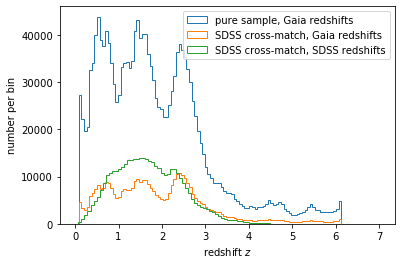

In [22]:
plt.hist(data['redshift_qsoc'], bins=100, histtype='step', label='pure sample, Gaia redshifts')
plt.hist(data_sdss_zgaia['redshift_qsoc'], bins=100, histtype='step', label='SDSS cross-match, Gaia redshifts')
plt.hist(data_sdss['redshift_sdss'], bins=100, histtype='step', label='SDSS cross-match, SDSS redshifts')
#plt.hist(redshift_sdss, bins=100, histtype='step')
plt.legend()
plt.xlabel(r'redshift $z$')
plt.ylabel('number per bin')

Text(0, 0.5, 'number per bin')

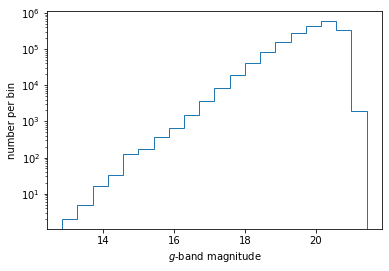

In [23]:
plt.hist(data['phot_g_mean_mag'], histtype='step', bins=20)
plt.yscale('log')
plt.xlabel(r'$g$-band magnitude')
plt.ylabel('number per bin')

## Plot slices

### Pure data set

Text(0, 0.5, 'dec (deg)')

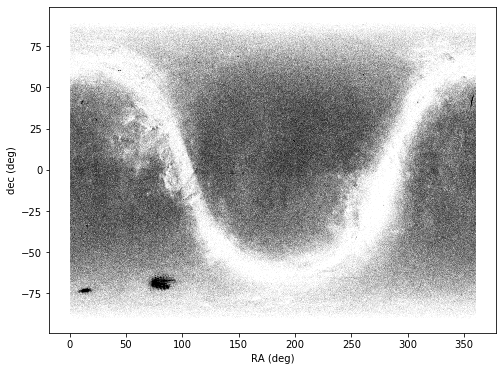

In [24]:
plt.figure(figsize=(8,6))
plt.scatter(data['ra'], data['dec'], s=0.01, alpha=0.1, c='k')
plt.xlabel('RA (deg)')
plt.ylabel('dec (deg)')

Text(0, 0.5, 'sin[b (galactic longitude, rad)]')

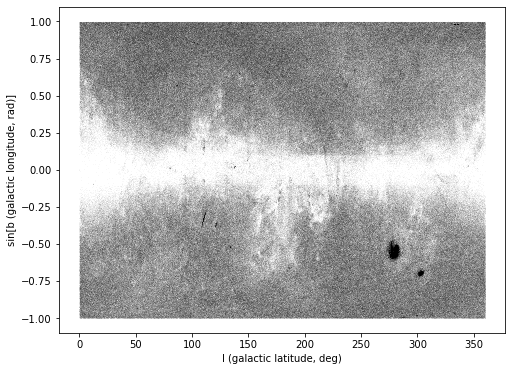

In [25]:
plt.figure(figsize=(8,6))
b_rad = data["b"] * np.pi/180
plt.scatter(data['l'], np.sin(b_rad), s=0.01, alpha=0.1, c='k')
plt.xlabel('l (galactic latitude, deg)')
plt.ylabel('sin[b (galactic longitude, rad)]')

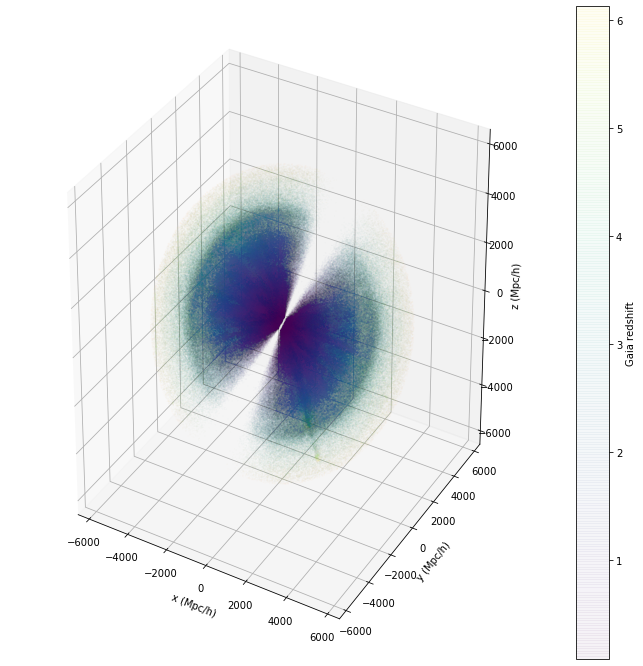

In [61]:
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')
scat = ax.scatter(data['x'], data['y'], data['z'], s=0.02, alpha=0.05, c=data['redshift_qsoc'])
ax.set_xlabel('x (Mpc/h)')
ax.set_ylabel('y (Mpc/h)')
ax.set_zlabel('z (Mpc/h)')
fig.colorbar(scat, label='Gaia redshift')

### With redshift, magnitude cuts

In [26]:
redshift_min = 0.5
redshift_max = 2.5
g_thresh = 20.2

In [27]:
idx_zslice = np.where((data['redshift_qsoc'] > redshift_min) & 
                      (data['redshift_qsoc'] < redshift_max) &
                      (data['phot_g_mean_mag'] < g_thresh))[0]
data_zslice = data[idx_zslice]
len(idx_zslice)

682748

Text(0, 0.5, 'dec (deg)')

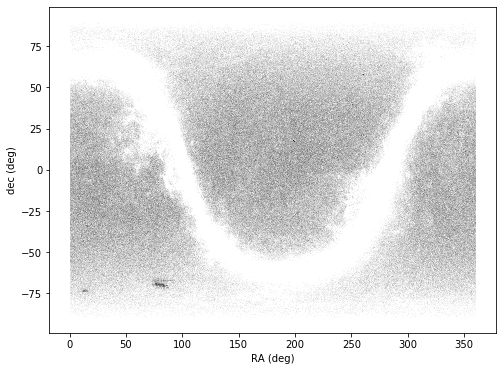

In [28]:
plt.figure(figsize=(8,6))
plt.scatter(data_zslice['ra'], data_zslice['dec'], s=0.01, alpha=0.1, c='k')
plt.xlabel('RA (deg)')
plt.ylabel('dec (deg)')

Text(0, 0.5, 'sin[b (galactic longitude, rad)]')

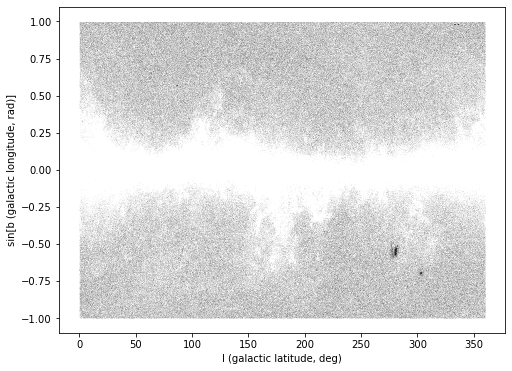

In [29]:
plt.figure(figsize=(8,6))
b_rad = data_zslice["b"] * np.pi/180
plt.scatter(data_zslice['l'], np.sin(b_rad), s=0.01, alpha=0.1, c='k')
plt.xlabel('l (galactic latitude, deg)')
plt.ylabel('sin[b (galactic longitude, rad)]')

### Cut out magellanic clouds

In [30]:
# the example from astropy is the magellanic clouds:
# https://docs.astropy.org/en/stable/coordinates/matchsep.html
coord_lmc = SkyCoord('5h23m34.5s', '-69d45m22s', frame='icrs')
coord_smc = SkyCoord('0h52m44.8s', '-72d49m43s', frame='icrs')

In [31]:
coords = SkyCoord(data['ra'], data['dec'], frame='icrs')

separations_lmc = coord_lmc.separation(coords).to(u.deg)
sep_max_lmc = 6*u.deg

separations_smc = coord_smc.separation(coords).to(u.deg)
sep_max_smc = 3*u.deg

idx_nomc = np.where((separations_lmc > sep_max_lmc ) &
                    (separations_smc > sep_max_smc ))[0]
print(len(data['ra']), len(idx_nomc), idx_nomc.max())

1942825 1913824 1942824


In [32]:
idx_zslice_nomc = np.where((data['redshift_qsoc'] > redshift_min) & 
                      (data['redshift_qsoc'] < redshift_max) &
                      (data['phot_g_mean_mag'] < g_thresh) &
                      (separations_lmc > sep_max_lmc ) &
                      (separations_smc > sep_max_smc ))[0]
len(idx_zslice_nomc)
data_zslice_nomc = data[idx_zslice_nomc]

Text(0, 0.5, 'dec (deg)')

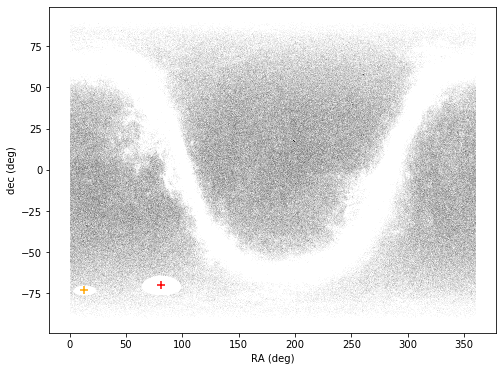

In [33]:
plt.figure(figsize=(8,6))
plt.scatter(data_zslice_nomc['ra'], data_zslice_nomc['dec'], s=0.01, alpha=0.1, c='k')
plt.scatter(coord_lmc.ra.to(u.deg), coord_lmc.dec.to(u.deg), s=50, c='r', marker='+')
plt.scatter(coord_smc.ra.to(u.deg), coord_smc.dec.to(u.deg), s=50, c='orange', marker='+')

plt.xlabel('RA (deg)')
plt.ylabel('dec (deg)')

Text(0, 0.5, 'sin[b (galactic longitude, rad)]')

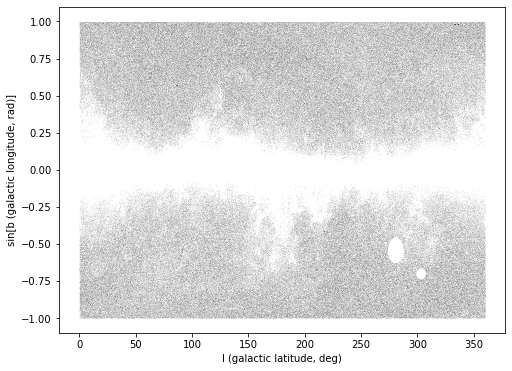

In [34]:
plt.figure(figsize=(8,6))
b_rad = data_zslice_nomc["b"] * np.pi/180
plt.scatter(data_zslice_nomc['l'], np.sin(b_rad), s=0.01, alpha=0.1, c='k')
plt.xlabel('l (galactic latitude, deg)')
plt.ylabel('sin[b (galactic longitude, rad)]')

SDSS:

Text(0, 0.5, 'dec (deg)')

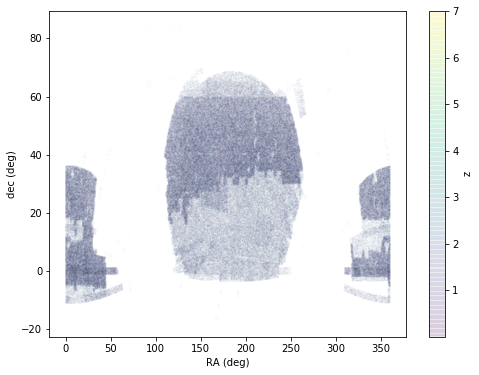

In [72]:
plt.figure(figsize=(8,6))
plt.scatter(data_sdss['ra'], data_sdss['dec'], s=0.01, alpha=0.1, c=data_sdss['redshift_sdss'])
plt.colorbar(label='z')
plt.xlabel('RA (deg)')
plt.ylabel('dec (deg)')

[0. 1. 2. 3. 4. 5. 6. 7.]


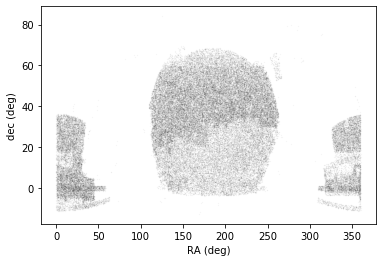

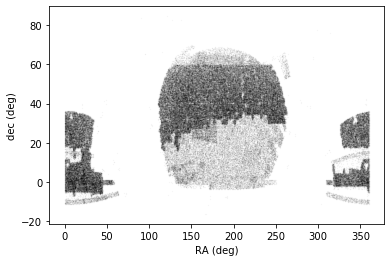

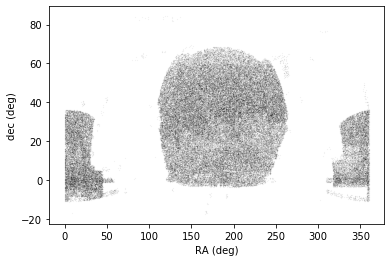

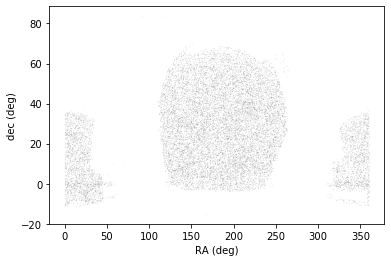

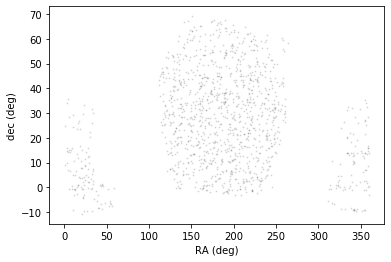

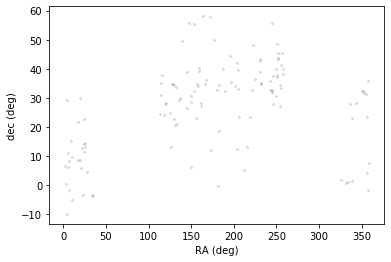

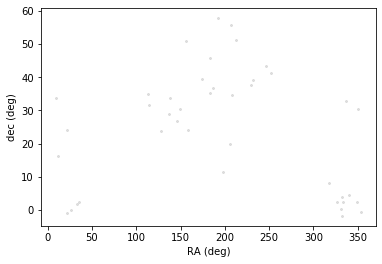

In [84]:
z_bin_edges = np.linspace(0, 7, 8)
ss = [0.02, 0.02, 0.03, 0.05, 1, 4, 4, 4]
print(z_bin_edges)
N_sdss = len(data_sdss)
for i in range(len(z_bin_edges)-1):
    idx_zbin = np.where((data_sdss['redshift_sdss'] > z_bin_edges[i]) & (data_sdss['redshift_sdss'] < z_bin_edges[i+1]))[0]
    N_zbin = len(idx_zbin)
    
    plt.figure(figsize=(6,4))
    plt.scatter(data_sdss['ra'][idx_zbin], data_sdss['dec'][idx_zbin], s=ss[i], alpha=0.1, 
                c='k')
    plt.xlabel('RA (deg)')
    plt.ylabel('dec (deg)')

Text(0, 0.5, 'sin[b (galactic longitude, rad)]')

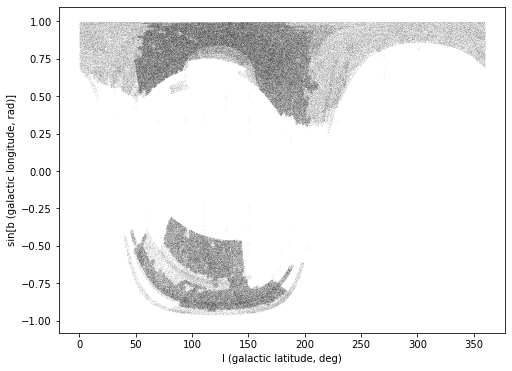

In [57]:
plt.figure(figsize=(8,6))
b_rad = data_sdss["b"] * np.pi/180
plt.scatter(data_sdss['l'], np.sin(b_rad), s=0.01, alpha=0.1, c='k')
plt.xlabel('l (galactic latitude, deg)')
plt.ylabel('sin[b (galactic longitude, rad)]')

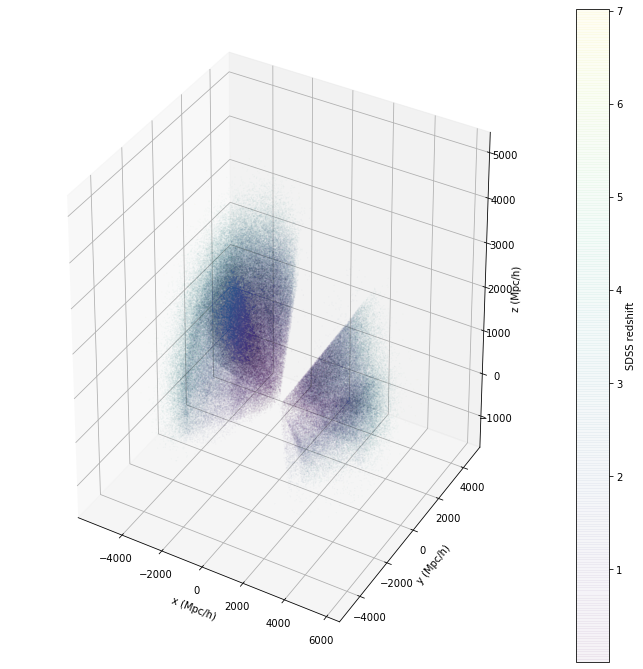

In [60]:
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')
scat = ax.scatter(data_sdss['x'], data_sdss['y'], data_sdss['z'], s=0.05, alpha=0.05, c=data_sdss['redshift_sdss'])
ax.set_xlabel('x (Mpc/h)')
ax.set_ylabel('y (Mpc/h)')
ax.set_zlabel('z (Mpc/h)')
fig.colorbar(scat, label='SDSS redshift')

## Random catalog

In [35]:
rng = default_rng(seed=42)

In [36]:
factor = 5

In [37]:
rand_zslice_nomc = generate_shuffled_random(factor, data_zslice_nomc, rng)
len(rand_zslice_nomc)

[ 60512 524748 443804 ... 374187 327626 113749]
[382172  43947 202496 ... 293742 181359 346220]


3390040

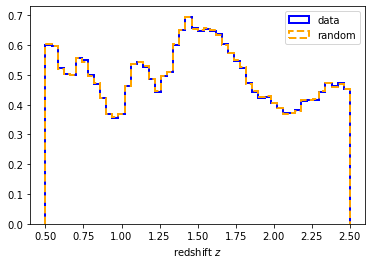

In [38]:
plt.hist(data_zslice_nomc['redshift_qsoc'], bins=50, histtype='step', color='blue', density=True, label='data', lw=2)
plt.hist(rand_zslice_nomc['redshift'], bins=50, histtype='step', color='orange', density=True, label='random', ls='--', lw=2)
plt.xlabel(r'redshift $z$')
plt.legend()

Text(0, 0.5, 'dec (deg)')

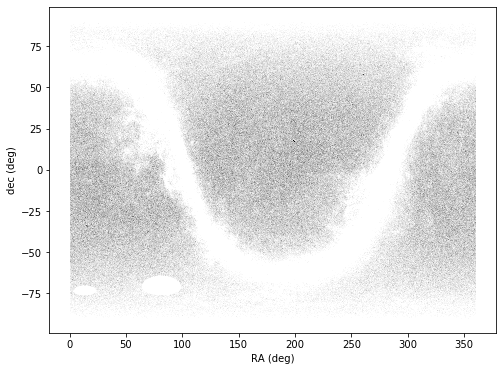

In [39]:
plt.figure(figsize=(8,6))
plt.scatter(rand_zslice_nomc['ra'], rand_zslice_nomc['dec'], s=0.03, alpha=0.01, c='k')

plt.xlabel('RA (deg)')
plt.ylabel('dec (deg)')

Make for other data catalogs:

In [40]:
rand_zslice = generate_shuffled_random(factor, data_zslice, rng)

[426567 101471 620213 ...  19341 434925 360068]
[102557 106469 280963 ... 243691  89717 297702]


In [41]:
rand_sdss = generate_shuffled_random(factor, data_sdss, rng, redshift_name='redshift_sdss')

[ 90236 327901 168168 ... 268674 222205 356271]
[ 18448 390575  92537 ... 320990  43829  83061]


In [42]:
rand_sdss_zgaia = generate_shuffled_random(factor, data_sdss_zgaia, rng, redshift_name='redshift_qsoc')

[127973 355204 375408 ... 119147 330673 262472]
[165007 110247 148808 ...  43933 107664 370542]


In [73]:
data_sdss_null = generate_shuffled_random(1, data_sdss, rng, redshift_name='redshift_sdss')

[299109 391139 189452 ... 182246 255576  21797]
[169349  64414 273106 ... 331564 133531  83340]


In [112]:
print(len(data_sdss['phot_g_mean_mag']))
print(len(data_sdss[np.isnan(data_sdss['phot_g_mean_mag'])]))
mag_nonzero = data_sdss['phot_g_mean_mag'][~np.isnan(data_sdss['phot_g_mean_mag'])]
mag_min = mag_nonzero.min()
mag_max = mag_nonzero.max()
len(mag_nonzero)

400543
6


400537

In [113]:
mag_bins = np.linspace(mag_min, mag_max, 10)
print(mag_bins)
rand_sdss_mbins = generate_shuffled_random_magbins(factor, data_sdss, rng, mag_bins,
                                           redshift_name='redshift_sdss', mag_name='phot_g_mean_mag')

[14.69120598 15.43055916 16.16991234 16.90926552 17.6486187  18.38797188
 19.12732506 19.86667824 20.60603142 21.3453846 ]


Text(0, 0.5, 'dec (deg)')

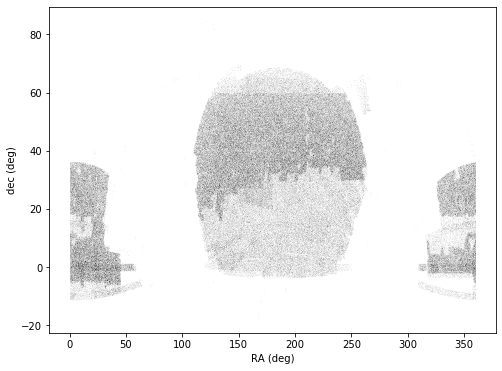

In [114]:
plt.figure(figsize=(8,6))
plt.scatter(rand_sdss_mbins['ra'], rand_sdss_mbins['dec'], s=0.03, alpha=0.01, c='k')

plt.xlabel('RA (deg)')
plt.ylabel('dec (deg)')

### try smaller area

In [133]:
data_sdss_small = data_sdss[(data_sdss['ra'] > 150) & (data_sdss['ra'] < 200) &
                            (data_sdss['dec'] > 0) & (data_sdss['dec'] < 20)]
print(len(data_sdss_small))

20288


Text(0, 0.5, 'dec (deg)')

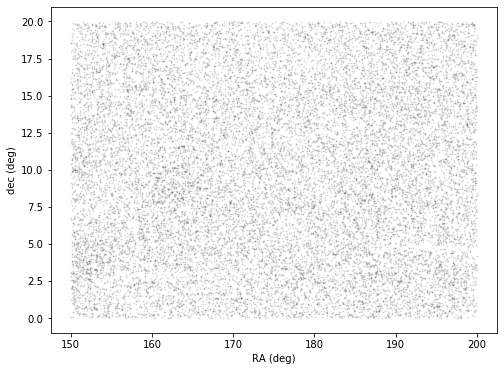

In [134]:
plt.figure(figsize=(8,6))
plt.scatter(data_sdss_small['ra'], data_sdss_small['dec'], s=1, alpha=0.1, c='k')

plt.xlabel('RA (deg)')
plt.ylabel('dec (deg)')

In [135]:
rand_sdss_small = generate_shuffled_random(factor, data_sdss_small, rng, redshift_name='redshift_sdss')

[ 1102 18656  2791 ...  1597 18991 13667]
[15540 19676 11040 ...  2138  1521 14085]


In [143]:
data_sdss_cent = data_sdss[(data_sdss['ra'] > 150) & (data_sdss['ra'] < 200) &
                            (data_sdss['dec'] > 25) & (data_sdss['dec'] < 36)]
print(len(data_sdss_cent))

20905


Text(0, 0.5, 'dec (deg)')

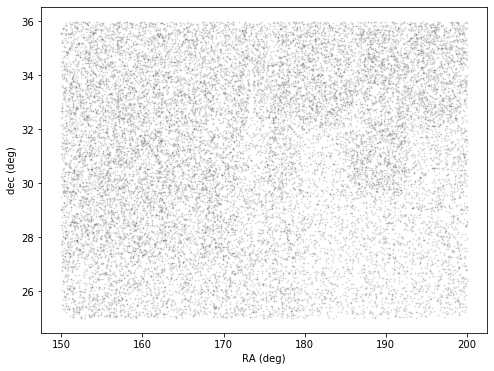

In [144]:
plt.figure(figsize=(8,6))
plt.scatter(data_sdss_cent['ra'], data_sdss_cent['dec'], s=1, alpha=0.1, c='k')

plt.xlabel('RA (deg)')
plt.ylabel('dec (deg)')

In [145]:
rand_sdss_cent = generate_shuffled_random(factor, data_sdss_cent, rng, redshift_name='redshift_sdss')

[ 1812  1242 15761 ... 20221 10109 11526]
[ 2185 16372 15539 ... 19382 14773  7520]


In [43]:
#rand = generate_shuffled_random(factor, data)

### try redshift bins 

In [159]:
redshift_bins = np.linspace(data_sdss['redshift_sdss'].min(), data_sdss['redshift_sdss'].max(), 10)
print(redshift_bins)
rand_sdss_zbins = generate_shuffled_random_zbins(factor, data_sdss, rng, redshift_bins,
                                           redshift_name='redshift_sdss')

[4.15325258e-03 7.82718977e-01 1.56128470e+00 2.33985043e+00
 3.11841615e+00 3.89698188e+00 4.67554760e+00 5.45411332e+00
 6.23267905e+00 7.01124477e+00]


## Real space pair counts

In [44]:
nthreads = 4
rmin, rmax = 20, 180
bin_size = 8
r_edges = np.arange(rmin, rmax+bin_size, bin_size)
r_avg = 0.5 * (r_edges[1:] + r_edges[:-1])

In [45]:
xi_zslice_nomc, res_dd, res_dr, res_rr = compute_xi(r_edges, data_zslice_nomc['x'], data_zslice_nomc['y'], data_zslice_nomc['z'], 
                                             rand_zslice_nomc['x'], rand_zslice_nomc['y'], rand_zslice_nomc['z'],
                                             return_full_results=True)

Time: 0.9985 s
Time: 6.2196 s
Time: 12.8785 s



In [46]:
def power_law(r, r0, alpha):
    return (r/r0)**(alpha)

def power_law_fixedslope(r, r0):
    return (r/r0)**2

# fix it to 2
#params_initial_guess = [0.04, 2]
#bounds = [[0, 0], [10, 10]]
params_initial_guess = [0.04]
bounds = [0, 10]

params_best_fit, _ = curve_fit(power_law_fixedslope, r_avg, res_dd['npairs'], p0=params_initial_guess, bounds=bounds)
print(params_best_fit)
power_law_fit = power_law_fixedslope(r_avg, *params_best_fit)

[0.06308413]


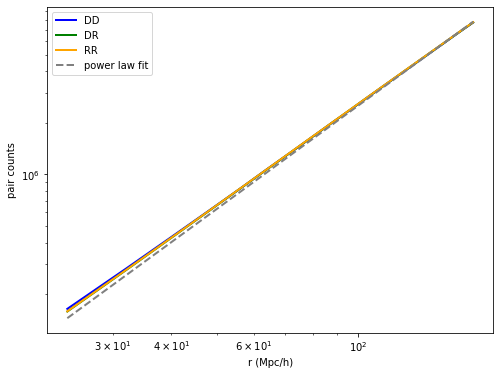

In [47]:
lw=2
plt.figure(figsize=(8,6))
plt.plot(r_avg, res_dd['npairs'], label='DD', color='blue', lw=lw)
plt.plot(r_avg, res_dr['npairs']/factor, label='DR', color='green', lw=lw)
plt.plot(r_avg, res_rr['npairs']/(factor**2), label='RR', color='orange', lw=lw)
#plt.plot(r_avg, res_rand['npairs'], label='random', color='orange', lw=lw)
#plt.plot(r_avg, power_law(r_avg, *params_in/itial_guess), label='initial', color='green', ls='--', lw=lw)
plt.plot(r_avg, power_law_fit, label='power law fit', color='grey', ls='--', lw=lw)
plt.xlabel('r (Mpc/h)')
plt.ylabel('pair counts')

plt.xscale('log')
plt.yscale('log')

plt.legend()

In [48]:
xi_zslice = compute_xi(r_edges, data_zslice['x'], data_zslice['y'], data_zslice['z'], 
                       rand_zslice['x'], rand_zslice['y'], rand_zslice['z'])

Time: 1.1338 s
Time: 6.1420 s
Time: 12.1729 s



In [49]:
xi_sdss = compute_xi(r_edges, data_sdss['x'], data_sdss['y'], data_sdss['z'], 
                       rand_sdss['x'], rand_sdss['y'], rand_sdss['z'])

Time: 0.6798 s
Time: 4.5053 s
Time: 9.1392 s



In [50]:
xi_sdss_zgaia = compute_xi(r_edges, data_sdss_zgaia['x'], data_sdss_zgaia['y'], data_sdss_zgaia['z'], 
                       rand_sdss_zgaia['x'], rand_sdss_zgaia['y'], rand_sdss_zgaia['z'])

Time: 0.7728 s
Time: 4.4259 s
Time: 9.7927 s



In [74]:
xi_sdss_null = compute_xi(r_edges, data_sdss_null['x'], data_sdss_null['y'], data_sdss_null['z'], 
                       rand_sdss['x'], rand_sdss['y'], rand_sdss['z'])

Time: 0.8533 s
Time: 4.9057 s
Time: 9.1761 s



In [115]:
xi_sdss_mbins = compute_xi(r_edges, data_sdss['x'], data_sdss['y'], data_sdss['z'], 
                       rand_sdss_mbins['x'], rand_sdss_mbins['y'], rand_sdss_mbins['z'])

Time: 0.7602 s
Time: 4.5833 s
Time: 9.0841 s



In [137]:
xi_sdss_small = compute_xi(r_edges, data_sdss_small['x'], data_sdss_small['y'], data_sdss_small['z'], 
                       rand_sdss_small['x'], rand_sdss_small['y'], rand_sdss_small['z'])

Time: 0.0363 s
Time: 0.1359 s
Time: 0.2285 s



In [146]:
xi_sdss_cent = compute_xi(r_edges, data_sdss_cent['x'], data_sdss_cent['y'], data_sdss_cent['z'], 
                       rand_sdss_cent['x'], rand_sdss_cent['y'], rand_sdss_cent['z'])

Time: 0.0503 s
Time: 0.2153 s
Time: 0.4129 s



In [160]:
xi_sdss_zbins = compute_xi(r_edges, data_sdss['x'], data_sdss['y'], data_sdss['z'], 
                       rand_sdss_zbins['x'], rand_sdss_zbins['y'], rand_sdss_zbins['z'])

Time: 0.8079 s
Time: 4.9493 s
Time: 9.9110 s



In [147]:
len(data_sdss_small), len(data_sdss_cent)

(20288, 20905)

In [116]:
# xi = compute_xi(r_edges, data['x'], data['y'], data['z'], 
#                 rand['x'], rand['y'], rand['z'])

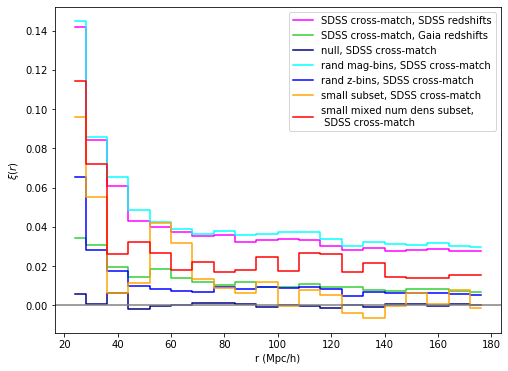

In [161]:
plt.figure(figsize=(8,6))
#plt.step(r_avg, res_dd['npairs']/power_law_fit-1, where='mid', color='blue', label=f'DD/powerlaw-1')
#plt.plot(r_avg, xi_natural, color='cyan', label=f'natural estimator')
#plt.step(r_avg, xi, where='mid', color='magenta', label=f'purer sample')
#plt.step(r_avg, xi_zslice, where='mid', color='purple', label=fr'${redshift_min} < z < {redshift_max}, g < {g_thresh}$')
#plt.step(r_avg, xi_zslice_nomc, where='mid', color='crimson', label=f'+ cut out LMC, SMC')
plt.step(r_avg, xi_sdss, where='mid', color='magenta', label=f'SDSS cross-match, SDSS redshifts')
plt.step(r_avg, xi_sdss_zgaia, where='mid', color='limegreen', label=f'SDSS cross-match, Gaia redshifts')
plt.step(r_avg, xi_sdss_null, where='mid', color='navy', label=f'null, SDSS cross-match')
plt.step(r_avg, xi_sdss_mbins, where='mid', color='cyan', label=f'rand mag-bins, SDSS cross-match')
plt.step(r_avg, xi_sdss_zbins, where='mid', color='blue', label=f'rand z-bins, SDSS cross-match')
plt.step(r_avg, xi_sdss_small, where='mid', color='orange', label=f'small subset, SDSS cross-match')
plt.step(r_avg, xi_sdss_cent, where='mid', color='red', label=f'small mixed num dens subset,\n SDSS cross-match')

#plt.step(r_avg, xi_func, where='mid', color='limegreen', label=f'L-S estimator (func)')

#plt.plot(r_avg, res_postsub['npairs']/power_law_fit_postsub, color='orange', label=f'{len(idx_postsub)} galaxies')
plt.xlabel('r (Mpc/h)')
plt.ylabel(r'$\xi(r)$')
plt.axhline(0, color='grey')
plt.legend()

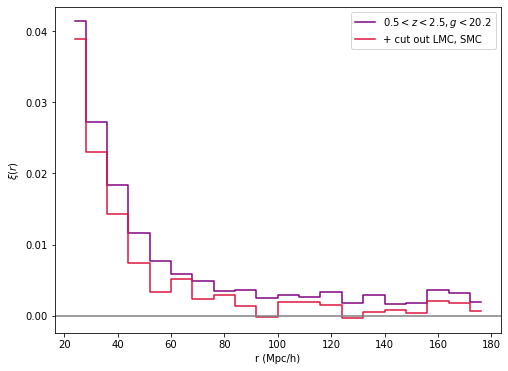

In [62]:
plt.figure(figsize=(8,6))
plt.step(r_avg, xi_zslice, where='mid', color='purple', label=fr'${redshift_min} < z < {redshift_max}, g < {g_thresh}$')
plt.step(r_avg, xi_zslice_nomc, where='mid', color='crimson', label=f'+ cut out LMC, SMC')

#plt.plot(r_avg, res_postsub['npairs']/power_law_fit_postsub, color='orange', label=f'{len(idx_postsub)} galaxies')
plt.xlabel('r (Mpc/h)')
plt.ylabel(r'$\xi(r)$')
plt.axhline(0, color='grey')
plt.legend()

Text(0, 0.5, '$g$-band magnitude')

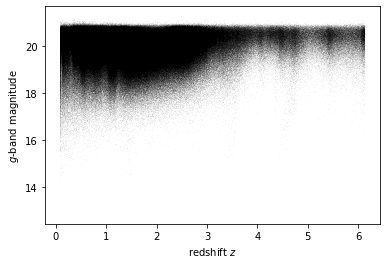

In [153]:
plt.scatter(data['redshift_qsoc'], data['phot_g_mean_mag'], s=0.01, alpha=0.1, color='k')
plt.xlabel(r'redshift $z$')
plt.ylabel(r'$g$-band magnitude')

## Real-space CF in redshift bins

In [65]:
z_bin_edges = [0.5, 1.0, 1.5, 2.0, 2.5]

xis_zbin = []
nthreads = 4

for i in range(len(z_bin_edges)-1):
    idx_zbin = np.where((data_zslice_nomc['redshift_qsoc'] > z_bin_edges[i]) & (data_zslice_nomc['redshift_qsoc'] < z_bin_edges[i+1]))[0]
    x_zbin = data_zslice_nomc['x'][idx_zbin]
    y_zbin = data_zslice_nomc['y'][idx_zbin]
    z_zbin = data_zslice_nomc['z'][idx_zbin]
    N_zbin = len(idx_zbin)
    
    idx_rand_zbin = np.where((rand_zslice_nomc['redshift'] > z_bin_edges[i]) & (rand_zslice_nomc['redshift'] < z_bin_edges[i+1]))[0]
    x_rand_zbin = rand_zslice_nomc['x'][idx_rand_zbin]
    y_rand_zbin = rand_zslice_nomc['y'][idx_rand_zbin]
    z_rand_zbin = rand_zslice_nomc['z'][idx_rand_zbin]
    N_rand_zbin = len(idx_rand_zbin)
    print(N_zbin, N_rand_zbin)
    
    xi_zbin = compute_xi(r_edges, x_zbin, y_zbin, z_zbin, 
                                  x_rand_zbin, y_rand_zbin, z_rand_zbin)

    xis_zbin.append(xi_zbin)

166232 830596
Time: 0.3076 s
Time: 1.8882 s
Time: 3.8629 s

184383 921764
Time: 0.2675 s
Time: 1.4579 s
Time: 2.9009 s

184669 924504
Time: 0.2814 s
Time: 1.4085 s
Time: 2.7953 s

142723 713173
Time: 0.2501 s
Time: 1.0521 s
Time: 1.7207 s



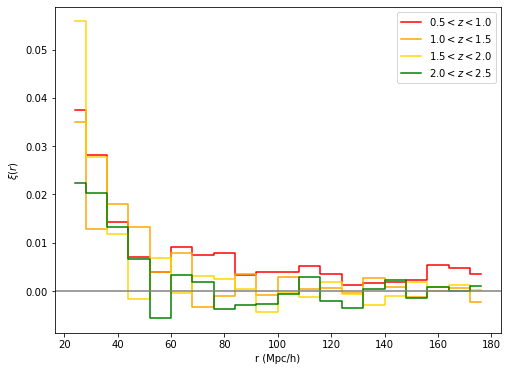

In [66]:
plt.figure(figsize=(8,6))
colors = ['red', 'orange', 'gold', 'green', 'cyan']
for i, xi_zbin in enumerate(xis_zbin):
    plt.step(r_avg, xi_zbin, where='mid', color=colors[i], label=fr'${z_bin_edges[i]} < z < {z_bin_edges[i+1]}$')
plt.xlabel('r (Mpc/h)')
plt.ylabel(r'$\xi(r)$')
plt.axhline(0, color='grey')
plt.legend()

## 2D and Projected CF

In [67]:
nthreads = 4

In [68]:
pimax = 150
nbins = 30
rp_bins = np.linspace(0.01, 150, nbins+1) 

In [ ]:
def compute_xi2d(rp_edges, pi_max, x, y, z, x_rand, y_rand, z_rand,
               return_full_results=False):
    
    nthreads = 4
    cosmology = 2 # don't need bc already converted to comoving distances; dummy value

    start = time.time()
    autocorr=1
DD_counts = DDrppi_mocks(autocorr, cosmology, nthreads, pimax, rp_bins,             
                         ra_zslice, dec_zslice, dist_zslice, is_comoving_dist=True)
    end = time.time()
    print(f'Time: {end-start:.4f} s')
    
    start = time.time()
    autocorr=0
DR_counts = DDrppi_mocks(autocorr, cosmology, nthreads, pimax, rp_bins,
                         ra_zslice, dec_zslice, dist_zslice,
                         RA2=ra_rand_zslice, DEC2=dec_rand_zslice, CZ2=dist_rand_zslice,
                         is_comoving_dist=True)
    end = time.time()
    print(f'Time: {end-start:.4f} s')

    start = time.time()
    autocorr=1
    res_rr = DD(autocorr, nthreads, r_edges, x_rand, y_rand, z_rand, periodic=False)
    end = time.time()
    print(f'Time: {end-start:.4f} s')
    print()
    
    N = len(x)
    N_rand = len(x_rand)
    xi = convert_3d_counts_to_cf(N, N, N_rand, N_rand,
                                     res_dd, res_dr,
                                     res_dr, res_rr)
    
    if return_full_results:
        return xi, res_dd, res_dr, res_rr
    
    return xi

In [ ]:
cosmology = 2 # don't need bc already converted to comoving distances; dummy value
autocorr = 1
start = time.time()
DD_counts = DDrppi_mocks(autocorr, cosmology, nthreads, pimax, rp_bins,             
                         ra_zslice, dec_zslice, dist_zslice, is_comoving_dist=True)
end = time.time()
print(f'Time: {end-start:.4f} s')

In [ ]:
# Cross pair counts in DR
autocorr = 0
start = time.time()
DR_counts = DDrppi_mocks(autocorr, cosmology, nthreads, pimax, rp_bins,
                         ra_zslice, dec_zslice, dist_zslice,
                         RA2=ra_rand_zslice, DEC2=dec_rand_zslice, CZ2=dist_rand_zslice,
                         is_comoving_dist=True)
end = time.time()
print(f'Time: {end-start:.4f} s')

In [ ]:
autocorr = 1
start = time.time()
RR_counts = DDrppi_mocks(autocorr, cosmology, nthreads, pimax, rp_bins,
                         ra_rand_zslice, dec_rand_zslice, dist_rand_zslice, is_comoving_dist=True)
end = time.time()
print(f'Time: {end-start:.4f} s')

In [ ]:
npibins = int(len(DD_counts['npairs'])/nbins)

dd = np.array(DD_counts['npairs'])
dd.resize((nbins, npibins))

dr = np.array(DR_counts['npairs'])
dr.resize((nbins, npibins))

rr = np.array(RR_counts['npairs'])
rr.resize((nbins, npibins))

In [ ]:
nonzero = rr > 0

fN = np.float64(N_rand) / np.float64(N)
cf = np.zeros((nbins, npibins))
cf[:] = np.nan
cf[nonzero] = (fN * fN * dd[nonzero] -
               2 * fN * dr[nonzero] +
               rr[nonzero]) / rr[nonzero]

In [ ]:
from matplotlib import colors
plt.figure(figsize=(8,8))
logthresh = 4
#plt.imshow(cf.T, extent=[0,9,0,80], aspect='auto', norm=colors.SymLogNorm(10**-logthresh), cmap='RdBu', 
#           vmin=-np.max(cf), vmax=np.max(cf), origin='lower')
# im = plt.imshow(np.log10(cf.T), extent=[0,max(rp_bins),0,npibins], aspect='auto', cmap='viridis_r', 
#            vmin=-1, vmax=1.5, origin='lower')
im = plt.imshow(cf.T, extent=[0,max(rp_bins),0,npibins], aspect='auto', cmap='viridis_r', 
            origin='lower')

ax = plt.gca()
ax.set_aspect('equal')
#plt.colorbar(im, fraction=0.03, pad=0.04, label=r'$\xi(r_\mathrm{p}, \pi)$')
plt.colorbar(im, label=r'$\xi(r_\mathrm{p}, \pi)$')

plt.ylabel(r'$\pi$')
plt.xlabel(r'$r_\mathrm{p}$')

In [ ]:
cf_tiled = np.empty((cf.shape[0]*2, cf.shape[1]*2))
cf_tiled[:nbins, :npibins] = cf[::-1, ::-1] # lower left
cf_tiled[nbins:, :npibins] = cf[:, ::-1] # lower right
cf_tiled[:nbins, npibins:] = cf[::-1, :] # upper left
cf_tiled[nbins:, npibins:] = cf # upper right

In [ ]:
from matplotlib import colors
plt.figure(figsize=(12,12))
logthresh = 4
#plt.imshow(cf_tiled.T, extent=[-nbins,nbins,-npibins,npibins], aspect='auto', norm=colors.SymLogNorm(10**-logthresh), cmap='RdBu', 
#           vmin=-np.max(cf), vmax=np.max(cf), origin='lower')
#print(np.min(np.log10(cf_tiled.T)), np.max(np.log10(cf_tiled.T)))
im = plt.imshow(cf_tiled.T, extent=[-max(rp_bins),max(rp_bins),-npibins,npibins], aspect='auto', cmap='viridis_r', 
                vmin=-0.05, vmax=0.05, 
                origin='lower')

ax = plt.gca()
ax.set_aspect('equal')
plt.colorbar(im, fraction=0.03, pad=0.04)

plt.ylabel(r'$\pi$')
plt.xlabel(r'$r_\mathrm{p}$')

In [ ]:
# All the pair counts are done, get the angular correlation function
wp = convert_rp_pi_counts_to_wp(N, N, N_rand, N_rand,
                                 DD_counts, DR_counts,
                                 DR_counts, RR_counts, nbins, pimax)

In [ ]:
rp_avg = 0.5*(rp_bins[:-1] + rp_bins[1:])
plt.plot(rp_avg, wp)
plt.yscale('log')
plt.xlabel(r'$r_\mathrm{p}$, projected separation ($h^{-1}$ Mpc)')
plt.ylabel(r'$w_\mathrm{p}(r_\mathrm{p})$')

## Angular CF

In [ ]:
def compute_wtheta(theta_edges, ra, dec, ra_rand, dec_rand):
    
    nthreads = 4
    
    autocorr = 1
    start = time.time()
    DD_theta = DDtheta_mocks(autocorr, nthreads, theta_edges, ra, dec)
    end = time.time()
    print(f'Time: {end-start:.4f} s')
    
    autocorr = 0
    start = time.time()
    DR_theta = DDtheta_mocks(autocorr, nthreads, theta_edges,
                               ra, dec,
                               RA2=ra_rand, DEC2=dec_rand)
    end = time.time()
    print(f'Time: {end-start:.4f} s')
    
    start = time.time()
    autocorr = 1
    RR_theta = DDtheta_mocks(autocorr, nthreads, theta_edges, ra_rand, dec_rand)
    end = time.time()
    print(f'Time: {end-start:.4f} s')
    
    N = len(ra)
    N_rand = len(ra_rand)
    wtheta = convert_3d_counts_to_cf(N, N, N_rand, N_rand,
                                 DD_theta, DR_theta,
                                 DR_theta, RR_theta)
    
    return wtheta

In [ ]:
nbins = 10
theta_bins = np.logspace(-2, 1, nbins + 1)
theta_avg = 10**(0.5*(np.log10(theta_bins[:-1]) + np.log10(theta_bins[1:])))
nthreads = 4
print(theta_bins)

In [ ]:
autocorr = 1
start = time.time()
DD_theta = DDtheta_mocks(autocorr, nthreads, theta_bins, ra_zslice, dec_zslice)
end = time.time()
print(f'Time: {end-start:.4f} s')

In [ ]:
autocorr = 0
start = time.time()
DR_theta = DDtheta_mocks(autocorr, nthreads, theta_bins,
                           ra_zslice, dec_zslice,
                           RA2=ra_rand_zslice, DEC2=dec_rand_zslice)
end = time.time()
print(f'Time: {end-start:.4f} s')

In [ ]:
start = time.time()
autocorr = 1
RR_theta = DDtheta_mocks(autocorr, nthreads, theta_bins, ra_rand_zslice, dec_rand_zslice)
end = time.time()
print(f'Time: {end-start:.4f} s')

In [ ]:
wtheta_real = convert_3d_counts_to_cf(N, N, N_rand, N_rand,
                                 DD_theta, DR_theta,
                                 DR_theta, RR_theta)

In [ ]:
plt.figure(figsize=(8,6))
plt.step(theta_avg, wtheta_real, where='mid', label='L-S estimator')
#plt.plot(theta_avg, DD_counts_real['npairs']/power_law_fit, label='DD/powerlaw - 1', color='grey')
plt.xscale('log')
#plt.yscale('log')
plt.xlabel(r'$\theta$, angular separation (deg)')
plt.ylabel(r'$w(\theta)$')
plt.legend()
#plt.ylim(0.1, 1)

In [ ]:
z_bin_edges = [0.5, 1.0, 1.5, 2.0, 2.5]

wthetas_zbin = []
nthreads = 4

for i in range(len(z_bin_edges)-1):
    idx_zbin = np.where((redshift_zslice > z_bin_edges[i]) & (redshift_zslice < z_bin_edges[i+1]))[0]
    ra_zbin = ra_zslice[idx_zbin]
    dec_zbin = dec_zslice[idx_zbin]
    N_zbin = len(idx_zbin)
    
    idx_rand_zbin = np.where((redshift_rand_zslice > z_bin_edges[i]) & (redshift_rand_zslice < z_bin_edges[i+1]))[0]
    ra_rand_zbin = ra_rand_zslice[idx_rand_zbin]
    dec_rand_zbin = dec_rand_zslice[idx_rand_zbin]
    N_rand_zbin = len(idx_rand_zbin)
    print(N_zbin, N_rand_zbin)
    
    wtheta_zbin = compute_wtheta(theta_edges, ra_zbin, dec_zbin, ra_rand_zbin, dec_rand_zbin)
    
    wthetas_zbin.append(wtheta_zbin)

In [ ]:
plt.figure(figsize=(8,6))
colors = ['red', 'orange', 'gold', 'green', 'cyan']
for i, wtheta_zbin in enumerate(wthetas_zbin):
    plt.step(r_avg, wtheta_zbin, where='mid', color=colors[i], label=fr'${z_bin_edges[i]} < z < {z_bin_edges[i+1]}$')
plt.xlabel(r'$\theta$, angular separation (deg)')
plt.ylabel(r'$w(\theta)$')
plt.axhline(0, color='grey')
plt.legend()

# SDSS cross-match sample 

In [ ]:
tab_gaia = Table.read('../data/GaiaDR3_QsoCandidates2.fits', format = 'fits')

In [ ]:
# tab_sdss = Table.read('../data/SDSS_DR16Q_v4.fits', format = 'fits')

# c1 = SkyCoord(ra=tab_sdss['RA']*u.degree, dec=tab_sdss['DEC']*u.degree, frame='icrs')   
# c2 = SkyCoord(ra=tab_gaia['ra'], dec=tab_gaia['dec'], frame='icrs') 

# #c2.match_to_catalog_sky(c1) 
# x1 = c2.search_around_sky(c1, 1*u.arcsec)
# x2 = c2.search_around_sky(c1, 2*u.arcsec)
# x3 = c2.search_around_sky(c1, 3*u.arcsec)

# # matched sample (~400,000 stars)
# tab_gaia = tab_gaia[x3[1]]

# # with redshifts
# tab_gaia.add_column(tab_sdss['Z'][x3[0]], name='redshift_sdss')

In [ ]:
# print(len(tab_gaia))
# tab_gaia = tab_gaia[tab_gaia['redshift_sdss'] > 0]
# print(len(tab_gaia))

In [ ]:
#tab_gaia['redshift_sdss'].min(), tab_gaia['redshift_sdss'].max()

In [ ]:
idx_pure = pure_cut(tab_gaia)
tab_pure = tab_gaia[idx_pure]
print(len(tab_pure))

In [ ]:
#plt.hist(tab_gaia['redshift_sdss'], bins=100, histtype='step', label='SDSS cross-match', color='cyan')
#plt.hist(tab_pure['redshift_sdss'], bins=100, histtype='step', label='+ Gaia pure cuts', color='blue')
plt.hist(tab_pure['redshift_qsoc'], bins=100, histtype='step', label='Gaia redshifts', color='purple')

plt.xlabel(r'redshift $z$')
plt.ylabel('number per bin')
plt.legend()

In [ ]:
plt.hist(tab_pure['phot_g_mean_mag'], histtype='step', bins=20)
plt.yscale('log')
plt.xlabel(r'$g$-band magnitude')
plt.ylabel('number per bin')

In [ ]:
print(len(tab_pure))
tab_pure = tab_pure[tab_pure['phot_g_mean_mag'] < 20.2]
print(len(tab_pure))
tab_pure = tab_pure[tab_pure['redshift_qsoc'] > 0.5]
print(len(tab_pure))
tab_pure = tab_pure[tab_pure['redshift_qsoc'] < 2.5]
print(len(tab_pure))

In [ ]:
cosmo = astropy.cosmology.Planck15
dist = (cosmo.comoving_distance(tab_pure['redshift_qsoc'])*cosmo.h).value # convert to Mpc/h
tab_pure.add_column(dist, name='distance_qsoc')

In [ ]:
x_sdssmatch, y_sdssmatch, z_sdssmatch = radec_to_cartesian(tab_pure['distance_qsoc'], tab_pure['ra'], tab_pure['dec'])
tab_pure.add_column(x_sdssmatch, name='x')
tab_pure.add_column(y_sdssmatch, name='y')
tab_pure.add_column(z_sdssmatch, name='z')

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(tab_pure['ra'], tab_pure['dec'], s=0.03, alpha=0.1, c='k')

plt.xlabel('RA (deg)')
plt.ylabel('dec (deg)')

In [ ]:
# tab_pure_ngc = tab_pure[(tab_pure['ra'] > 100) & (tab_pure['ra'] < 290)]
# print(len(tab_pure_ngc))

In [ ]:
# plt.figure(figsize=(8,6))
# plt.scatter(tab_pure_ngc['ra'], tab_pure_ngc['dec'], s=0.03, alpha=0.1, c='k')

# plt.xlabel('RA (deg)')
# plt.ylabel('dec (deg)')

In [ ]:
factor = 10

In [ ]:
tab_rand = generate_shuffled_random(factor, tab_pure['ra'], tab_pure['dec'], 
                                            tab_pure['redshift_qsoc'], tab_pure['distance_qsoc'])

In [ ]:
# len(tab_pure_ngc['ra'])
# len(tab_rand['ra'])

In [ ]:
x_rand_sdssmatch, y_rand_sdssmatch, z_rand_sdssmatch = radec_to_cartesian(tab_rand['distance'], 
                                                                          tab_rand['ra'], 
                                                                          tab_rand['dec'])
tab_rand.add_column(x_rand_sdssmatch, name='x')
tab_rand.add_column(y_rand_sdssmatch, name='y')
tab_rand.add_column(z_rand_sdssmatch, name='z')

In [ ]:
print(len(tab_pure))
print(len(tab_rand))

### Plot

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(tab_rand['ra'], tab_rand['dec'], s=0.03, alpha=0.1/factor, c='k')

plt.xlabel('RA (deg)')
plt.ylabel('dec (deg)')

In [ ]:
plt.hist(tab_pure['redshift_qsoc'], bins=20, histtype='step', lw=2, label='data', color='blue')
plt.hist(tab_rand['redshift'], bins=20, histtype='step', lw=2, label='random', ls='--', color='orange')
plt.legend()
plt.xlabel(r'redshift $z$')
plt.ylabel('number in bin')

### Correlation function

In [ ]:
rmin, rmax = 20, 180
bin_size = 8
r_edges = np.arange(rmin, rmax+bin_size, bin_size)
r_avg = 0.5 * (r_edges[1:] + r_edges[:-1])

In [ ]:
xi_zsdss, res_dd, res_dr, res_rr = compute_xi(r_edges,
                tab_pure['x'], tab_pure['y'], tab_pure['z'],
                tab_rand['x'], tab_rand['y'], tab_rand['z'],
                return_full_results=True)

In [ ]:
lw=2
plt.figure(figsize=(8,6))
plt.plot(r_avg, res_dd['npairs'], label='DD', color='blue', lw=lw)
plt.plot(r_avg, res_dr['npairs']/factor, label='DR', color='green', lw=lw)
plt.plot(r_avg, res_rr['npairs']/(factor**2), label='RR', color='orange', lw=lw)
#plt.plot(r_avg, power_law(r_avg, *params_in/itial_guess), label='initial', color='green', ls='--', lw=lw)
#plt.plot(r_avg, power_law_fit, label='power law fit', color='grey', ls='--', lw=lw)
plt.xlabel('r (Mpc/h)')
plt.ylabel('pair counts')

plt.xscale('log')
plt.yscale('log')

plt.legend()

In [ ]:
plt.figure(figsize=(8,6))
#plt.step(r_avg, res_dd['npairs']/power_law_fit-1, where='mid', color='blue', label=f'DD/powerlaw-1')
#plt.plot(r_avg, xi_natural, color='cyan', label=f'natural estimator')
plt.step(r_avg, xi_zsdss, where='mid', color='magenta', label=f'L-S estimator')
#plt.plot(r_avg, res_postsub['npairs']/power_law_fit_postsub, color='orange', label=f'{len(idx_postsub)} galaxies')
plt.xlabel('r (Mpc/h)')
plt.ylabel(r'$\xi(r)$')
plt.axhline(0, color='grey')
plt.legend()